Initialize the tracking procedure:

In [1]:
from tramway.analyzer import *

a = RWAnalyzer()

a.tracker.from_non_tracking()
a.tracker.dt = .04
a.tracker.localization_precision = .025
a.tracker.estimated_high_diffusivity = .3


/home/flaurent/github/RWA-python/rwa/hdf5.py:185: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel # Panel has been flagged deprecated


Retrieve the test data:

In [2]:
from tutorial import download_non_tracking_test_data
download_non_tracking_test_data()

Track a first localization data file:

In [3]:
trajectories = a.tracker.track('../data-examples/c04_high_density.tsf.xyt', register=True)

Track another localization data file:

In [4]:
trajectories = a.tracker.track('../data-examples/Manip02-01-Beta400AA-03-15ms.rpt.xyt', register=True)

Check the trajectories are available in the analyzer for further processing:

In [5]:
import os.path

a.spt_data.alias = lambda path: os.path.basename(path).split('.')[0]

for f in a.spt_data:
    # the `trajectories` dataframes are registered in the central `spt_data` analyzer attribute
    print('\n{}:\n{}\n\n'.format(f.alias, f.dataframe))


c04_high_density:
           n        x        y      t
0          1  22.8733  32.3726   0.04
1          1  23.0586  32.3189   0.08
2          1  23.0423  32.4401   0.12
3          2  19.2069  43.7014   0.04
4          2  19.2621  43.6810   0.08
...      ...      ...      ...    ...
55752  20158  34.4110  26.3598  80.04
55753  20159  36.5694  42.7222  80.00
55754  20159  36.6469  42.7924  80.04
55755  20160  58.5587  52.9951  80.00
55756  20160  58.5511  52.8064  80.04

[55757 rows x 4 columns]



Manip02-01-Beta400AA-03-15ms:
             n          x          y        t
0            1   1.675908  18.623232      1.0
1            1   1.707381  18.620911      2.0
2            1   1.495254  18.684129      3.0
3            1   1.553280  18.704008      4.0
4            1   1.474511  18.718771      5.0
...        ...        ...        ...      ...
607825  187884  10.460133   3.176812  20000.0
607826  187885  31.871252  18.505996  19998.0
607827  187885  32.002370  18.596178  19999.0
607828

Visualize a few frame pairs (about 15, starting from time `t0`) and the corresponding matching:

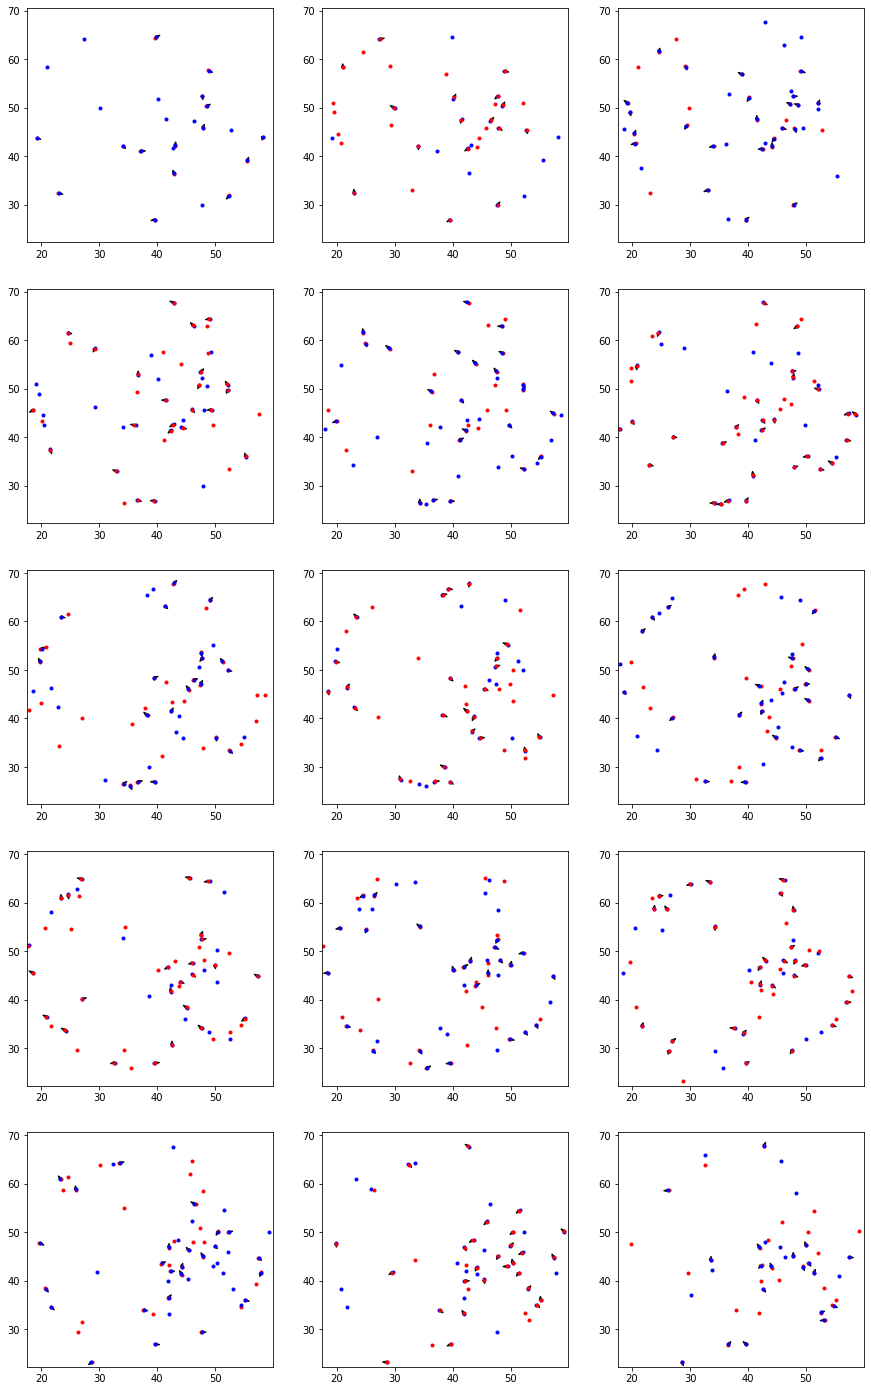

In [6]:
%matplotlib inline

from tramway.core.xyt import iter_frames
import matplotlib.pyplot as plt
import numpy as np

n_cols = 3
max_n_rows = 5
colors = 'rb' # colors alternate between frames (frame 0 in red, frame 1 in blue, frame 2 in red again, etc)
t0 = 0

for f in a.spt_data.filter_by_source('c04_high_density'):
    dt = f.dt
    df = f.dataframe
    tlim, xlim, ylim = f.bounds[list('txy')].values.T
    #
    t_start, t_stop = tlim
    if t_stop<=t0:
        raise ValueError('t0 is too large')
    t_start = max(t0, t_start)
    n_frames = int(np.round((t_stop-t_start)/dt)) + 1
    n_rows = int(np.ceil(float(n_frames) / n_cols))
    n_rows = min(n_rows, max_n_rows)
    fig, ax = plt.subplots(n_rows,n_cols,figsize=(5*n_cols,5*n_rows))
    #
    df = df[t0<=df['t']]
    #
    it = iter_frames(df, dt=dt)
    i = 0
    first = next(it)
    t_first = df['t'].iloc[first[0]]
    while True:
        try:
            second = next(it)
        except StopIteration:
            break
        t_second = df['t'].iloc[second[0]]
        contiguous = np.isclose(t_second - t_first, dt)
        if contiguous:
            frame0, frame1 = df.iloc[first], df.iloc[second]
            matching_n = set(frame0['n']) & set(frame1['n'])
            r,c = divmod(i, n_cols)
            ax[r,c].set_xlim(xlim)
            ax[r,c].set_ylim(ylim)
            ax[r,c].plot(frame0['x'],frame0['y'],colors[i%len(colors)]+'.')
            ax[r,c].plot(frame1['x'],frame1['y'],colors[(i+1)%len(colors)]+'.')
            for n in matching_n:
                _, x0, y0, _ = frame0[frame0['n']==n].values[0]
                _, x1, y1, _ = frame1[frame1['n']==n].values[0]
                ax[r,c].arrow(x0, y0, x1-x0, y1-y0, head_width=.5)
        i += 1
        if i == n_rows*n_cols:
            break
        first, t_first = second, t_second
        

Plot the trajectories as an animation:

In [7]:
%%capture

f = next(iter(a.spt_data)) # take the first file

fig, ax = plt.subplots(frameon=False, figsize=(12,12))

anim = f.mpl.animate(fig, axes=ax, interval='2x', save_count=200) # the first 200 frames only, at half speed


In [8]:
from IPython.display import HTML

HTML(anim.to_jshtml())

Define further processing steps:

In [9]:
a.tesseller = tessellers.KMeans
a.tesseller.resolution = .1 # optional; default value is determined from the average displacement length

a.sampler.from_nearest_neighbors(20) # optional; merely makes `a.sampler` visible

a.mapper.from_plugin('dd') # diffusivity and drift
# regularization always takes a lot of time...
#a.mapper.diffusivity_prior = 1.
#a.mapper.drift_prior = 1.

Process the tracked data and plot the resulting maps:

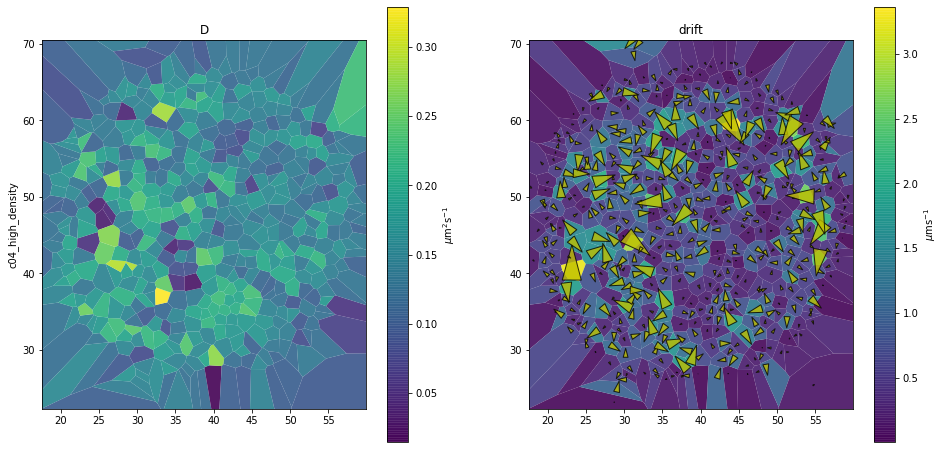

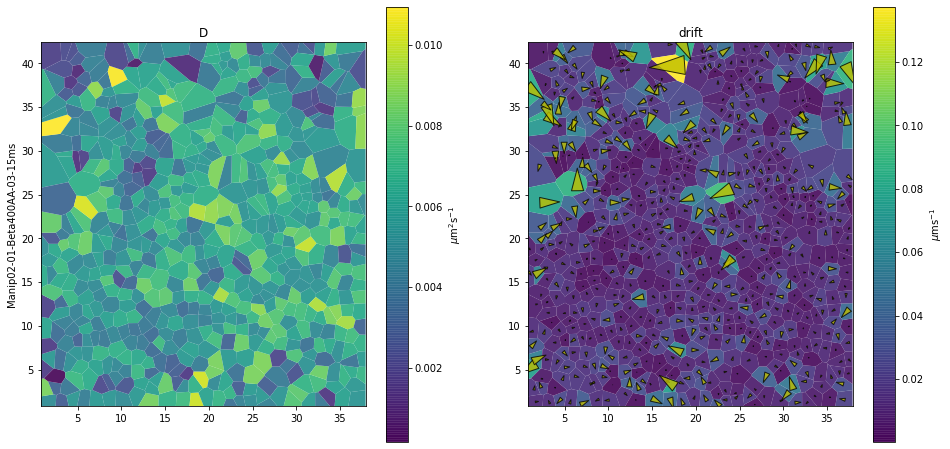

In [10]:
from tramway.helper.inference import map_plot

plot_options = dict(aspect='equal', unit='std', show=False)

for f in a.spt_data:
    
    # tessellate and assign translocations to bins
    sampling = a.sampler.sample(f.dataframe) # implicitly calls a.tesseller.tessellate
    
    # infer
    maps = a.mapper.infer(sampling)
    
    # plot
    fig, ax = plt.subplots(1,2,figsize=(16,8))
    map_plot(maps, sampling, feature='diffusivity', title='D', axes=ax[0], **plot_options)
    ax[0].set_ylabel(f.alias)
    map_plot(maps, sampling, feature='drift', title='drift', axes=ax[1], **plot_options)
    